In [44]:
# Read libraries and data
import torch
import pandas as pd
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [45]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [46]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    #Creating the dataset
    context = []
    X , Y = [], []
    for w in words: 

        context = [0] * block_size  

        for i in w + '.':
            idx = stoi[i]
            X.append(context)
            Y.append(idx)
            #print(f"{context} -> {i}")
            context = context[1:] + [idx]
        #print("-----------------")

    X = torch.tensor(X)    
    Y = torch.tensor(Y)    
    print(X.shape,Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2: ])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [49]:
for p in parameters:
  p.requires_grad = True

In [50]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [51]:
lri = []
lossi = []
steps= []
gradi = []
loop = 200000

In [52]:
for i in range(loop):

    #batches
    idx = torch.randint(0, Xtr.shape[0], (32,)) # [32]

    #Forward
    emb = C[Xtr[idx]] # [32x3x10]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32x300] 
    logits = h @ W2 + b2 # [32x27]
    loss = F.cross_entropy(logits,Ytr[idx])
    #print(loss.item())

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update the parameters
    loops1 = loop * 0.1
    loops2 = loop * 0.5
    if i < loops1:
        lr = 0.1
    elif (i > loops1) & (i < loops2):
        lr = 0.05
    elif i > loops2:
        lr = 0.01    

    for p in parameters:
        p.data -= p.grad * lr

    if i % 1000 == 0:    
        gradi.append(lr)
        lossi.append(loss.item())
        steps.append(i) 

#Create a dataframe with the results
df = pd.DataFrame({'Steps': steps, 'Learning Rate': gradi, 'Loss': lossi})

print(loss)

tensor(2.4944, grad_fn=<NllLossBackward0>)


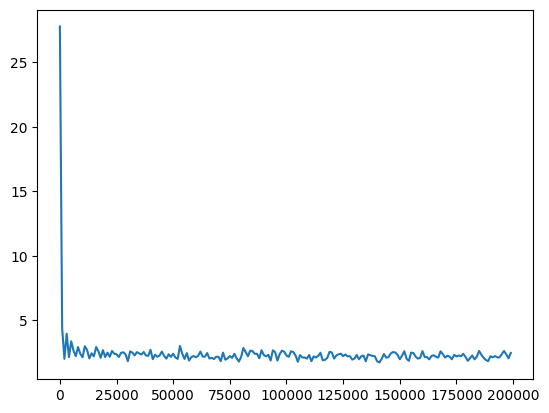

In [53]:
plt.plot(steps, lossi)

In [54]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1650, grad_fn=<NllLossBackward0>)

In [55]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2033, grad_fn=<NllLossBackward0>)

In [56]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1938, grad_fn=<NllLossBackward0>)

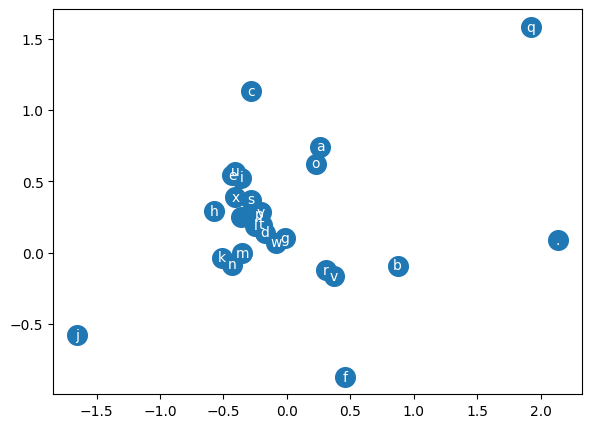

In [57]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(26):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha= 'center', va= 'center', color = 'white') 

In [66]:
g = torch.Generator().manual_seed(2147483647 +11)
block_size = 3
generated_names = []

for _ in range(100):

    out = []
    context = block_size * [0]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim = 1)
        ix = torch.multinomial(prob, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    generated_name = ''.join(itos[i] for i in out)
    generated_names.append(generated_name)

    
    print(''.join(itos[i] for i in out))

# Create a DataFrame from the generated names
df = pd.DataFrame(generated_names, columns=['Generated Names'])

reenai.
rah.
zarghan.
neah.
zika.
ker.
malya.
srain.
eem.
jaxmeeri.
tamela.
karaanis.
malzee.
kenlie.
aue.
jed.
les.
lor.
kalexs.
thaqfaeshes.
kashabitlah.
jalaya.
benah.
lissa.
blaya.
alrias.
dyxenn.
kyra.
frida.
cheb.
azzawaleigo.
jatuse.
kasya.
larrigaafdommaun.
emoniyah.
aan.
harian.
tamaruf.
zaher.
javeen.
tayder.
esaniph.
ter.
amaema.
eesa.
artiariel.
kaserizia.
have.
kah.
junia.
daver.
enser.
ese.
jouma.
marieliss.
kaya.
alee.
pera.
hanna.
rhis.
iim.
jani.
eman.
alaz.
min.
trick.
vii.
rasher.
maver.
katilla.
johalliyah.
pria.
darion.
jivone.
kum.
nack.
linixg.
kemari.
bayah.
yulah.
marya.
riz.
bryleiganif.
nia.
yesiel.
naley.
per.
milomee.
dan.
sszosiffania.
satel.
buxlea.
preou.
xay.
daliani.
pen.
koralie.
esifiriapin.
aumellie.
ila.


In [68]:
df.head(50)

,Generated Names
0,reenai.
1,rah.
2,zarghan.
3,neah.
4,zika.
5,ker.
6,malya.
7,srain.
8,eem.
9,jaxmeeri.
